In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
import time
from typing import Dict, List, Tuple, Optional
import json
from datetime import datetime

# Deep Learning imports
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks
    from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
    from tensorflow.keras.applications import (
        MobileNetV2, EfficientNetB0, ResNet50V2,
        DenseNet121, Xception
    )
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

    # Enable mixed precision for better GPU utilization
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

    print(f"TensorFlow version: {tf.__version__}")
    print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")
    print("Mixed precision enabled for better GPU efficiency")

except ImportError:
    print("TensorFlow not available - please install: pip install tensorflow")
    exit()

# ML evaluation imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score,
                           confusion_matrix, f1_score, precision_score, recall_score)

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

TensorFlow version: 2.19.0
GPU available: True
Mixed precision enabled for better GPU efficiency
All libraries imported successfully!


In [2]:
class Config:
    """Configuration for methane leak detection"""

    # Detect environment
    import sys
    IS_COLAB = 'google.colab' in sys.modules

    if IS_COLAB:
        BASE_PATH = Path('/content/drive/MyDrive/contours')
        OUTPUT_BASE = Path('/content/drive/MyDrive/output')
        print("Running in Google Colab")
    else:
        BASE_PATH = Path('./contours')
        OUTPUT_BASE = Path('./output')
        print("Running locally")

    # Image settings
    IMG_HEIGHT = 224
    IMG_WIDTH = 224
    IMG_CHANNELS = 3
    SUPPORTED_FORMATS = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']

    # Training settings
    BATCH_SIZE = 8
    EPOCHS = 20
    LEARNING_RATE = 0.001
    PATIENCE = 7

    # Augmentation
    ROTATION_RANGE = 15
    ZOOM_RANGE = 0.1
    HORIZONTAL_FLIP = True

    # Paths
    OUTPUT_DIR = OUTPUT_BASE
    MODEL_DIR = OUTPUT_DIR / 'models'

# Create directories
for dir_path in [Config.OUTPUT_DIR, Config.MODEL_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

print(f"Base path: {Config.BASE_PATH}")
print(f"Expected structure:")
print(f"  {Config.BASE_PATH}/leak/")
print(f"  {Config.BASE_PATH}/no_leak/")

Running in Google Colab
Base path: /content/drive/MyDrive/contours
Expected structure:
  /content/drive/MyDrive/contours/leak/
  /content/drive/MyDrive/contours/no_leak/


In [3]:
class ImageLoader:
    """Load pre-labeled thermal images"""

    def __init__(self, max_per_class=200):
        self.max_per_class = max_per_class
        self.class_names = ['No Leak', 'Leak']

    def discover_images(self):
        """Find images in leak and no_leak folders"""
        print("Discovering images...")
        all_images = []

        leak_path = Config.BASE_PATH / 'leak'
        no_leak_path = Config.BASE_PATH / 'no_leak'

        # Load leak images
        if leak_path.exists():
            leak_count = 0
            for ext in Config.SUPPORTED_FORMATS:
                images = list(leak_path.glob(f'*{ext}')) + list(leak_path.glob(f'*{ext.upper()}'))
                for img in images:
                    all_images.append((img, 1))
                    leak_count += len(images)
            print(f"Found {leak_count} leak images")
        else:
            print(f"Leak folder not found: {leak_path}")

        # Load no-leak images
        if no_leak_path.exists():
            no_leak_count = 0
            for ext in Config.SUPPORTED_FORMATS:
                images = list(no_leak_path.glob(f'*{ext}')) + list(no_leak_path.glob(f'*{ext.upper()}'))
                for img in images:
                    all_images.append((img, 0))
                    no_leak_count += len(images)
            print(f"Found {no_leak_count} no-leak images")
        else:
            print(f"No-leak folder not found: {no_leak_path}")

        print(f"Total: {len(all_images)} images")
        return all_images

    def create_dataset(self, image_data):
        """Create balanced dataset"""
        leak_images = []
        no_leak_images = []

        for img_path, label in image_data:
            if label == 1 and len(leak_images) < self.max_per_class:
                leak_images.append((str(img_path), 1))
            elif label == 0 and len(no_leak_images) < self.max_per_class:
                no_leak_images.append((str(img_path), 0))

        all_data = leak_images + no_leak_images
        np.random.shuffle(all_data)

        paths, labels = zip(*all_data) if all_data else ([], [])
        print(f"Dataset: {len(leak_images)} leak, {len(no_leak_images)} no-leak")

        return list(paths), list(labels)

    def load_images(self, paths, labels):
        """Load and preprocess images"""
        print(f"Loading {len(paths)} images...")

        images, valid_labels, valid_paths = [], [], []

        for i, (path, label) in enumerate(zip(paths, labels)):
            try:
                img = load_img(path, target_size=(Config.IMG_HEIGHT, Config.IMG_WIDTH))
                img_array = img_to_array(img) / 255.0

                images.append(img_array)
                valid_labels.append(label)
                valid_paths.append(path)

                if (i + 1) % 50 == 0:
                    print(f"Loaded {i + 1}/{len(paths)} images")

            except Exception as e:
                print(f"Skipped {Path(path).name}: {e}")

        if images:
            print(f"Successfully loaded {len(images)} images")
            return np.array(images), np.array(valid_labels), valid_paths
        else:
            return np.array([]), np.array([]), []

# Load data
loader = ImageLoader()
discovered_data = loader.discover_images()

if len(discovered_data) == 0:
    print("No images found! Please organize images as:")
    print(f"  {Config.BASE_PATH}/leak/")
    print(f"  {Config.BASE_PATH}/no_leak/")
    X_images, y_images, image_paths = np.array([]), np.array([]), []
else:
    paths, labels = loader.create_dataset(discovered_data)
    X_images, y_images, image_paths = loader.load_images(paths, labels)

Discovering images...
Found 84681 leak images
Found 29584 no-leak images
Total: 463 images
Dataset: 200 leak, 172 no-leak
Loading 372 images...
Loaded 50/372 images
Loaded 100/372 images
Loaded 150/372 images
Loaded 200/372 images
Loaded 250/372 images
Loaded 300/372 images
Loaded 350/372 images
Successfully loaded 372 images



Dataset Statistics:
Total images: 372
Leak samples: 200 (53.8%)
No leak samples: 172 (46.2%)


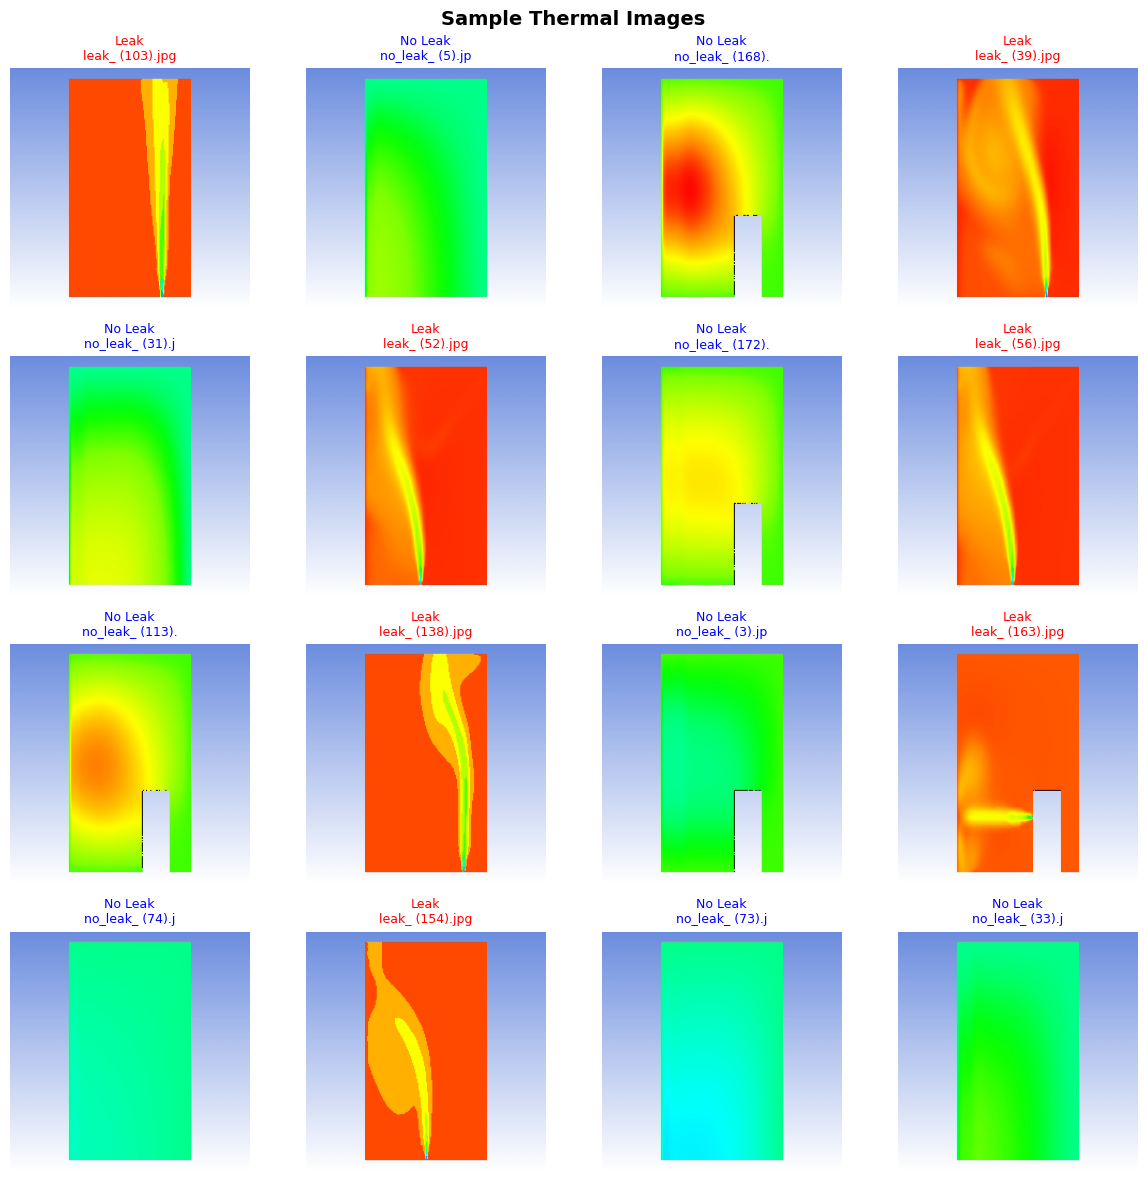

In [5]:
if len(X_images) > 0:
    print(f"\nDataset Statistics:")
    print(f"Total images: {len(X_images)}")
    print(f"Leak samples: {np.sum(y_images == 1)} ({np.mean(y_images == 1):.1%})")
    print(f"No leak samples: {np.sum(y_images == 0)} ({np.mean(y_images == 0):.1%})")

    # Sample visualization
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Sample Thermal Images', fontsize=14, fontweight='bold')

    sample_indices = np.random.choice(len(X_images), min(16, len(X_images)), replace=False)

    for i, idx in enumerate(sample_indices):
        row, col = i // 4, i % 4
        ax = axes[row, col]

        ax.imshow(X_images[idx])

        label = "Leak" if y_images[idx] == 1 else "No Leak"
        color = 'red' if y_images[idx] == 1 else 'blue'

        ax.set_title(f"{label}\n{Path(image_paths[idx]).name[:15]}", fontsize=9, color=color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No images available")

In [9]:
class TransferModels:
    """Create transfer learning models"""

    @staticmethod
    def create_model(base_name='MobileNetV2'):
        """Create transfer learning model"""
        print(f"Creating {base_name} model...")

        models_dict = {
            'MobileNetV2': MobileNetV2,
            'EfficientNetB0': EfficientNetB0,
            'DenseNet121': DenseNet121,
        }

        base_model = models_dict[base_name](
            weights='imagenet',
            include_top=False,
            input_shape=(Config.IMG_HEIGHT, Config.IMG_WIDTH, Config.IMG_CHANNELS)
        )

        base_model.trainable = False

        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.3),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(1, activation='sigmoid', dtype='float32')
        ], name=f'Transfer_{base_name}')

        print(f"Created {base_name}: {model.count_params():,} parameters")
        return model

def create_models():
    """Create all model architectures"""
    models_dict = {}

    for model_name in ['MobileNetV2', 'EfficientNetB0', 'DenseNet121']:
        try:
            model = TransferModels.create_model(model_name)
            models_dict[model_name] = model
        except Exception as e:
            print(f"Failed to create {model_name}: {e}")

    return models_dict

if len(X_images) > 0:
    model_architectures = create_models()
    print(f"Created {len(model_architectures)} models")

Creating MobileNetV2 model...
Created MobileNetV2: 2,422,593 parameters
Creating EfficientNetB0 model...
Created EfficientNetB0: 4,214,180 parameters
Creating DenseNet121 model...
Created DenseNet121: 7,169,345 parameters
Created 3 models


In [10]:
class Trainer:
    """Model training pipeline"""

    def __init__(self):
        self.models = {}
        self.histories = {}
        self.results = {}
        self.best_model_name = None

    def prepare_data(self, X, y):
        """Split data"""
        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

        print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

    def create_callbacks(self, model_name):
        """Training callbacks"""
        return [
            EarlyStopping(monitor='val_accuracy', patience=Config.PATIENCE, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
        ]

    def train_model(self, model, model_name, train_data, val_data):
        """Train single model"""
        print(f"\nTraining {model_name}...")

        X_train, y_train = train_data
        X_val, y_val = val_data

        model.compile(
            optimizer=Adam(learning_rate=Config.LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # Data augmentation
        train_gen = ImageDataGenerator(
            rotation_range=Config.ROTATION_RANGE,
            zoom_range=Config.ZOOM_RANGE,
            horizontal_flip=Config.HORIZONTAL_FLIP,
            fill_mode='nearest'
        )
        val_gen = ImageDataGenerator()

        start_time = time.time()

        history = model.fit(
            train_gen.flow(X_train, y_train, batch_size=Config.BATCH_SIZE),
            steps_per_epoch=len(X_train) // Config.BATCH_SIZE,
            epochs=Config.EPOCHS,
            validation_data=val_gen.flow(X_val, y_val, batch_size=Config.BATCH_SIZE),
            validation_steps=len(X_val) // Config.BATCH_SIZE,
            callbacks=self.create_callbacks(model_name),
            verbose=1
        )

        training_time = time.time() - start_time

        self.models[model_name] = model
        self.histories[model_name] = history

        best_val_acc = max(history.history['val_accuracy'])
        self.results[model_name] = {
            'val_accuracy': best_val_acc,
            'training_time': training_time,
            'epochs': len(history.history['loss'])
        }

        print(f"Completed {model_name}: {best_val_acc:.3f} accuracy in {training_time:.1f}s")

        # Clear memory
        tf.keras.backend.clear_session()
        import gc
        gc.collect()

    def train_all(self, models_dict, train_data, val_data):
        """Train all models"""
        for model_name, model in models_dict.items():
            self.train_model(model, model_name, train_data, val_data)

        if self.results:
            self.best_model_name = max(self.results.keys(), key=lambda x: self.results[x]['val_accuracy'])
            print(f"\nBest model: {self.best_model_name}")

    def evaluate_test(self, test_data):
        """Evaluate on test set"""
        X_test, y_test = test_data
        test_results = {}

        print("\nEvaluating on test set...")

        for model_name, model in self.models.items():
            y_pred_proba = model.predict(X_test, batch_size=Config.BATCH_SIZE, verbose=0)
            y_pred = (y_pred_proba > 0.5).astype(int).flatten()

            test_results[model_name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'f1_score': f1_score(y_test, y_pred),
                'roc_auc': roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0.5,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba.flatten()
            }

            print(f"{model_name}: {test_results[model_name]['accuracy']:.3f} accuracy")

        return test_results

# Train models
if len(X_images) > 0 and 'model_architectures' in locals():
    print("\nStarting training...")

    trainer = Trainer()
    train_data, val_data, test_data = trainer.prepare_data(X_images, y_images)

    # Train all models
    trainer.train_all(model_architectures, train_data, val_data)

    # Evaluate
    test_results = trainer.evaluate_test(test_data)

    # Results summary
    print(f"\nFinal Results:")
    for model_name, results in test_results.items():
        print(f"{model_name}: {results['accuracy']:.3f} accuracy, {results['f1_score']:.3f} F1")


Starting training...
Train: 222, Val: 75, Test: 75

Training MobileNetV2...
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7823 - loss: 0.4440 - val_accuracy: 1.0000 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0757 - val_accuracy: 1.0000 - val_loss: 0.0347 - learning_rate: 0.0010
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9523 - loss: 0.1312 - val_accuracy: 0.9861 - val_loss: 0.0216 - learning_rate: 0.0010
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0172 - val_accuracy: 0.9861 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9935 - loss: 0.0389 - val_accuracy: 0.9861 - val_loss: 0.0204 - learning_rate: 0.0010
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0158 - val_accuracy: 0.9861 - val_loss: 0.0199 - learning_rate: 0.0010
Epoch 7/20
27/27 ━━

Creating comprehensive analysis visualizations...


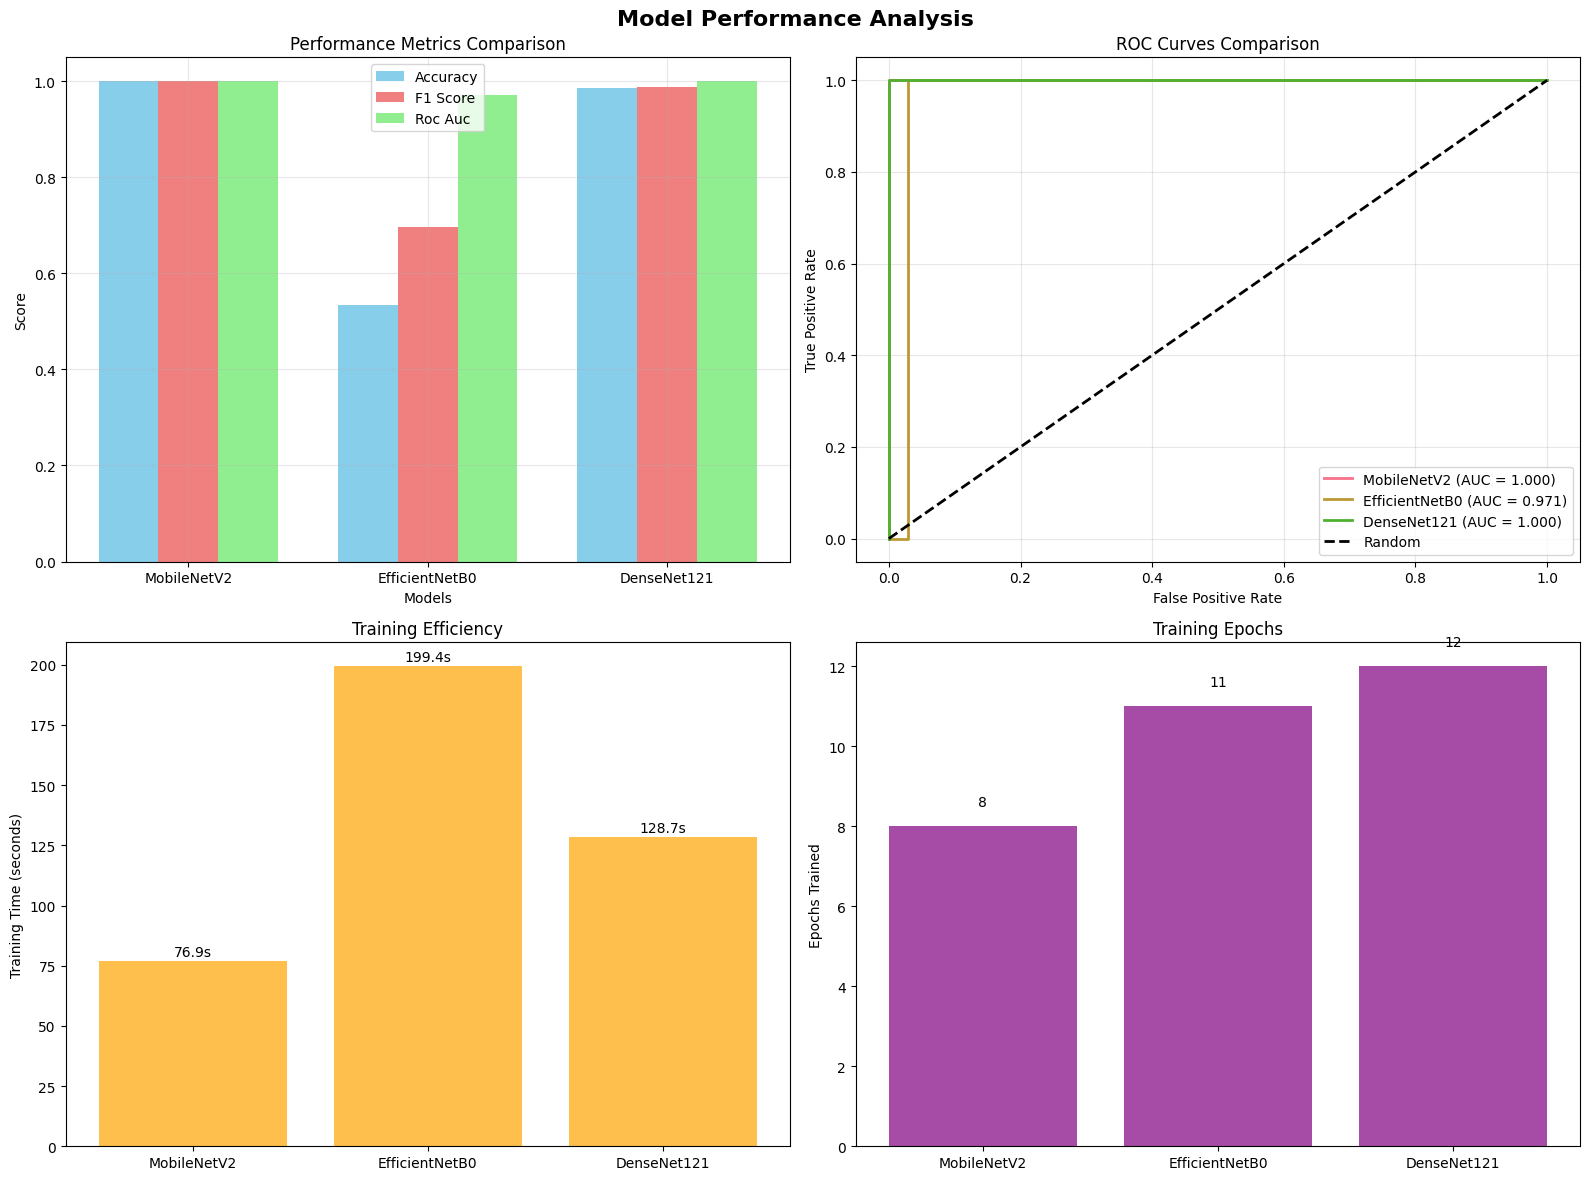

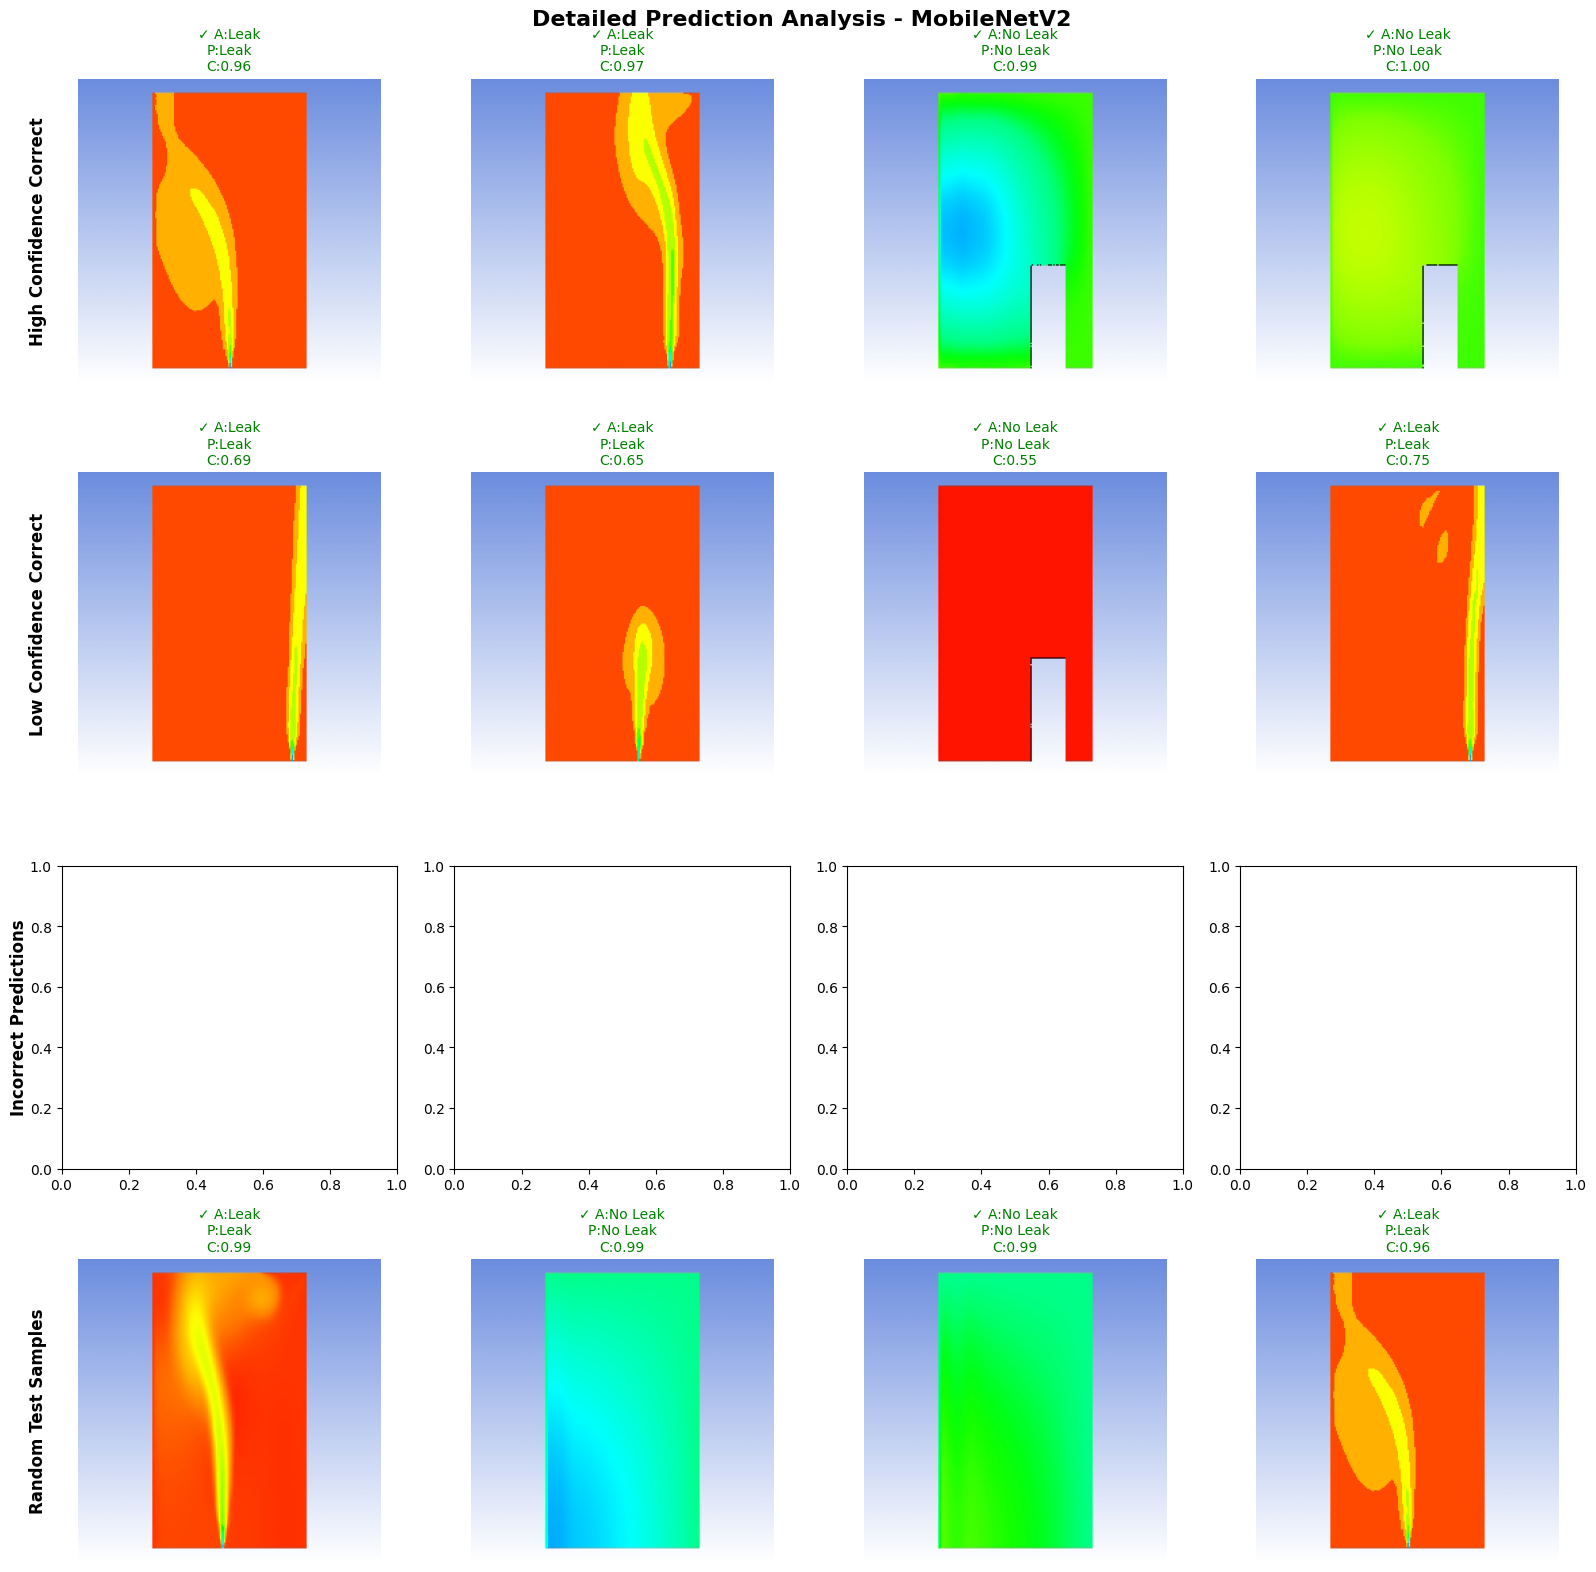

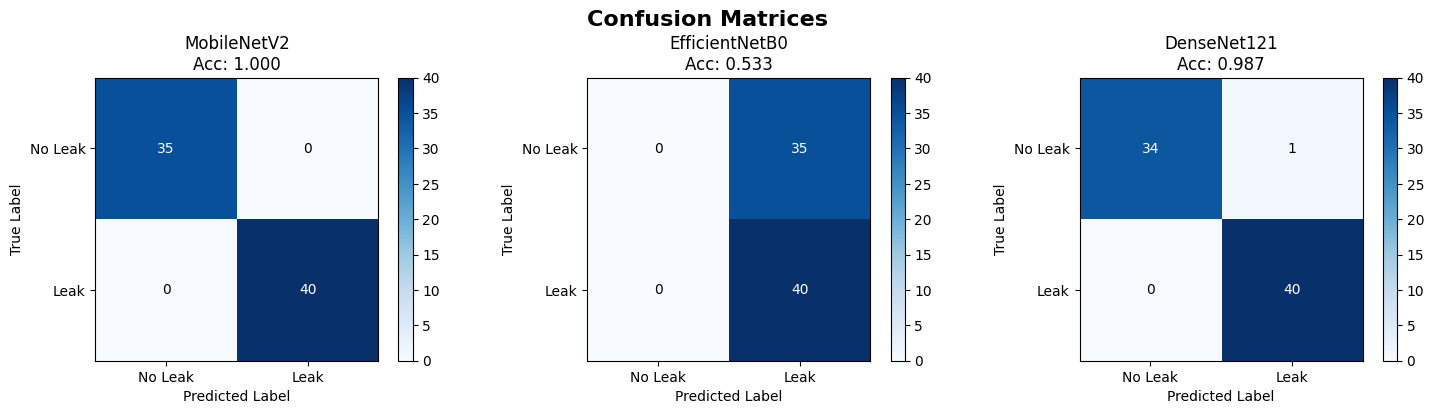

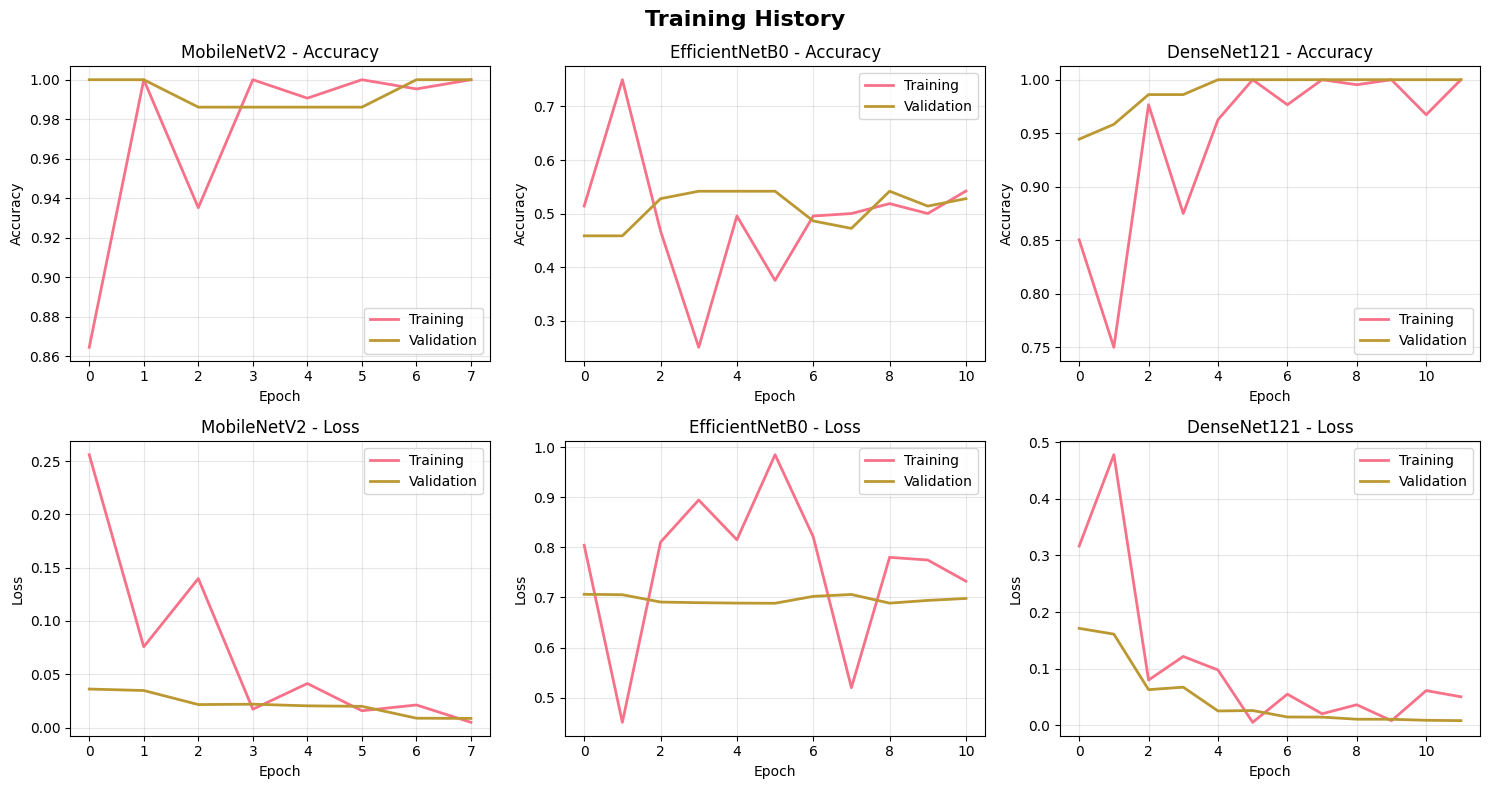

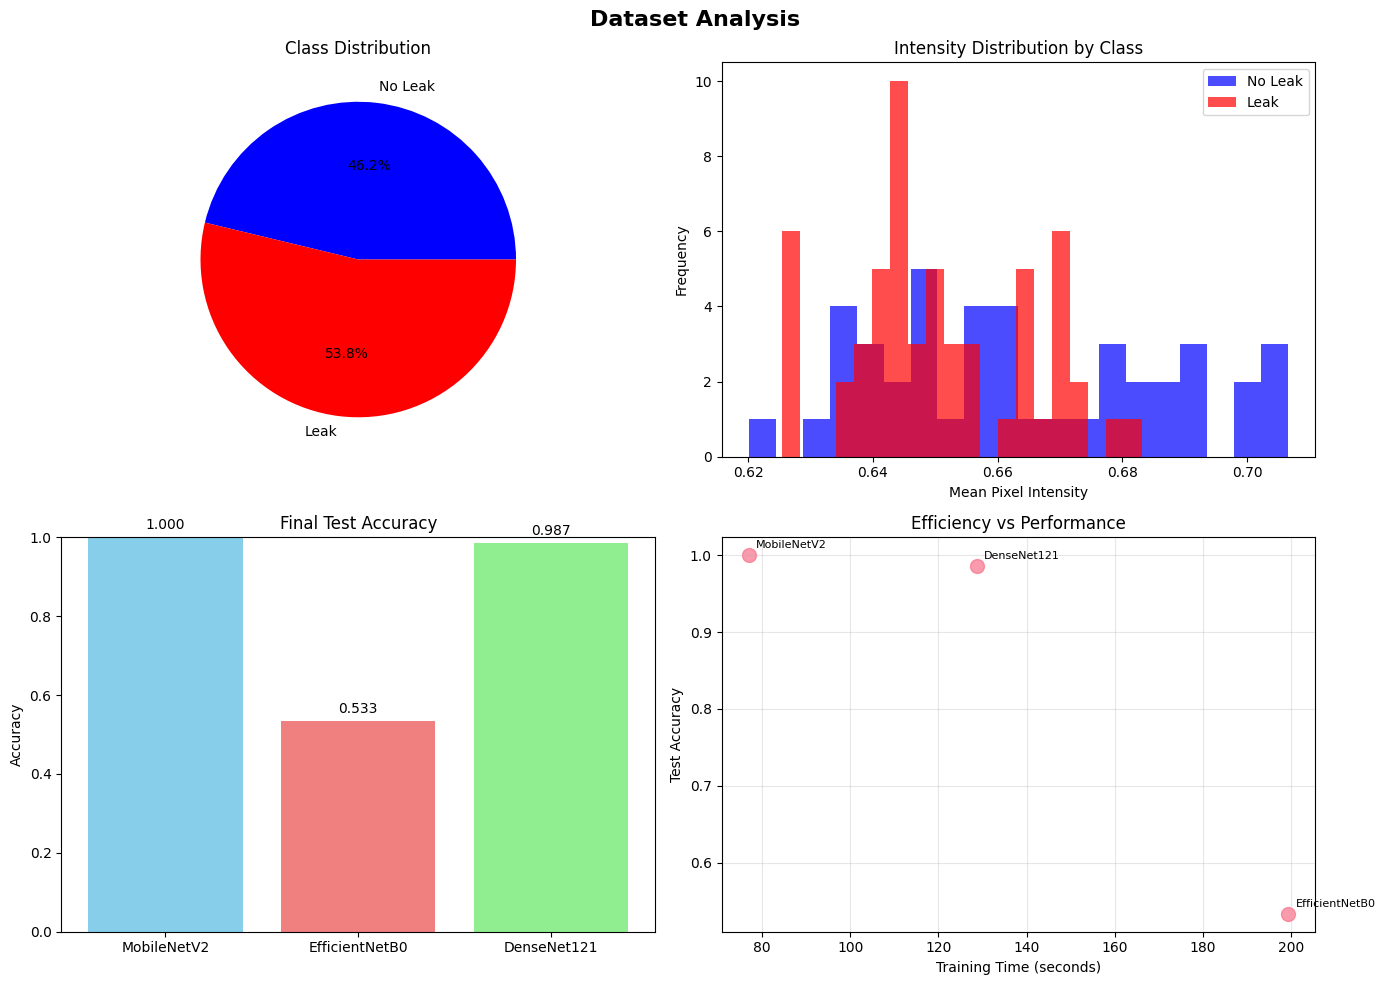

In [11]:
if len(X_images) > 0 and 'test_results' in locals():
    print("Creating comprehensive analysis visualizations...")

    # 1. Model Performance Comparison
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

    models = list(test_results.keys())

    # Performance metrics
    metrics = ['accuracy', 'f1_score', 'roc_auc']
    x = np.arange(len(models))
    width = 0.25
    colors = ['skyblue', 'lightcoral', 'lightgreen']

    for i, metric in enumerate(metrics):
        values = [test_results[model][metric] for model in models]
        ax1.bar(x + i*width, values, width, label=metric.replace('_', ' ').title(), color=colors[i])

    ax1.set_xlabel('Models')
    ax1.set_ylabel('Score')
    ax1.set_title('Performance Metrics Comparison')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(models)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # ROC Curves
    X_test, y_test = test_data
    for model_name in models:
        if len(np.unique(y_test)) > 1:
            y_pred_proba = test_results[model_name]['y_pred_proba']
            from sklearn.metrics import roc_curve, auc
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            ax2.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

    ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curves Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Training efficiency
    times = [trainer.results[model]['training_time'] for model in models]
    epochs = [trainer.results[model]['epochs'] for model in models]

    ax3.bar(models, times, color='orange', alpha=0.7)
    ax3.set_ylabel('Training Time (seconds)')
    ax3.set_title('Training Efficiency')
    for i, (model, time_val) in enumerate(zip(models, times)):
        ax3.text(i, time_val + max(times)*0.01, f'{time_val:.1f}s', ha='center')

    # Epochs comparison
    ax4.bar(models, epochs, color='purple', alpha=0.7)
    ax4.set_ylabel('Epochs Trained')
    ax4.set_title('Training Epochs')
    for i, (model, epoch_val) in enumerate(zip(models, epochs)):
        ax4.text(i, epoch_val + 0.5, f'{epoch_val}', ha='center')

    plt.tight_layout()
    plt.show()

    # 2. Detailed Prediction Analysis
    if trainer.best_model_name:
        best_model = trainer.models[trainer.best_model_name]
        y_pred_proba = best_model.predict(X_test, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()

        # Find different prediction types
        correct_indices = np.where(y_pred == y_test)[0]
        incorrect_indices = np.where(y_pred != y_test)[0]
        high_conf_correct = [i for i in correct_indices if abs(y_pred_proba[i][0] - 0.5) > 0.3]
        low_conf_correct = [i for i in correct_indices if abs(y_pred_proba[i][0] - 0.5) <= 0.3]

        fig, axes = plt.subplots(4, 4, figsize=(16, 16))
        fig.suptitle(f'Detailed Prediction Analysis - {trainer.best_model_name}', fontsize=16, fontweight='bold')

        sample_types = [
            ('High Confidence Correct', high_conf_correct[:4]),
            ('Low Confidence Correct', low_conf_correct[:4]),
            ('Incorrect Predictions', incorrect_indices[:4]),
            ('Random Test Samples', np.random.choice(len(X_test), 4, replace=False))
        ]

        for row, (title, indices) in enumerate(sample_types):
            for col, idx in enumerate(indices):
                ax = axes[row, col]

                if idx < len(X_test):
                    ax.imshow(X_test[idx])

                    actual = "Leak" if y_test[idx] else "No Leak"
                    predicted = "Leak" if y_pred[idx] else "No Leak"
                    confidence = y_pred_proba[idx][0] if y_pred[idx] else 1 - y_pred_proba[idx][0]

                    correct_symbol = "✓" if y_pred[idx] == y_test[idx] else "✗"
                    color = 'green' if y_pred[idx] == y_test[idx] else 'red'

                    title_text = f"{correct_symbol} A:{actual}\nP:{predicted}\nC:{confidence:.2f}"
                    ax.set_title(title_text, fontsize=10, color=color)

                ax.axis('off')

            # Add row labels
            axes[row, 0].text(-0.1, 0.5, title, rotation=90, va='center', ha='right',
                             transform=axes[row, 0].transAxes, fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.show()

    # 3. Confusion Matrices
    num_models = len(test_results)
    fig, axes = plt.subplots(1, num_models, figsize=(5*num_models, 4))
    fig.suptitle('Confusion Matrices', fontsize=16, fontweight='bold')

    if num_models == 1:
        axes = [axes]

    for i, (model_name, results) in enumerate(test_results.items()):
        cm = confusion_matrix(y_test, results['y_pred'])

        im = axes[i].imshow(cm, interpolation='nearest', cmap='Blues')
        axes[i].figure.colorbar(im, ax=axes[i])

        # Add text annotations
        thresh = cm.max() / 2.
        for j in range(cm.shape[0]):
            for k in range(cm.shape[1]):
                axes[i].text(k, j, format(cm[j, k], 'd'),
                           ha="center", va="center",
                           color="white" if cm[j, k] > thresh else "black")

        axes[i].set_title(f'{model_name}\nAcc: {results["accuracy"]:.3f}')
        axes[i].set_ylabel('True Label')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_xticks([0, 1])
        axes[i].set_yticks([0, 1])
        axes[i].set_xticklabels(['No Leak', 'Leak'])
        axes[i].set_yticklabels(['No Leak', 'Leak'])

    plt.tight_layout()
    plt.show()

    # 4. Training History Visualization
    if trainer.histories:
        num_models = len(trainer.histories)
        fig, axes = plt.subplots(2, num_models, figsize=(5*num_models, 8))
        fig.suptitle('Training History', fontsize=16, fontweight='bold')

        if num_models == 1:
            axes = axes.reshape(2, 1)

        for i, (model_name, history) in enumerate(trainer.histories.items()):
            # Accuracy
            axes[0, i].plot(history.history['accuracy'], label='Training', linewidth=2)
            axes[0, i].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
            axes[0, i].set_title(f'{model_name} - Accuracy')
            axes[0, i].set_xlabel('Epoch')
            axes[0, i].set_ylabel('Accuracy')
            axes[0, i].legend()
            axes[0, i].grid(True, alpha=0.3)

            # Loss
            axes[1, i].plot(history.history['loss'], label='Training', linewidth=2)
            axes[1, i].plot(history.history['val_loss'], label='Validation', linewidth=2)
            axes[1, i].set_title(f'{model_name} - Loss')
            axes[1, i].set_xlabel('Epoch')
            axes[1, i].set_ylabel('Loss')
            axes[1, i].legend()
            axes[1, i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # 5. Dataset Analysis
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Dataset Analysis', fontsize=16, fontweight='bold')

    # Class distribution
    class_counts = [np.sum(y_images == 0), np.sum(y_images == 1)]
    class_labels = ['No Leak', 'Leak']
    colors = ['blue', 'red']

    axes[0, 0].pie(class_counts, labels=class_labels, autopct='%1.1f%%', colors=colors)
    axes[0, 0].set_title('Class Distribution')

    # Sample intensity analysis
    sample_indices = np.random.choice(len(X_images), min(100, len(X_images)), replace=False)
    leak_intensities = []
    no_leak_intensities = []

    for idx in sample_indices:
        intensity = np.mean(X_images[idx])
        if y_images[idx] == 1:
            leak_intensities.append(intensity)
        else:
            no_leak_intensities.append(intensity)

    if leak_intensities and no_leak_intensities:
        axes[0, 1].hist(no_leak_intensities, bins=20, alpha=0.7, label='No Leak', color='blue')
        axes[0, 1].hist(leak_intensities, bins=20, alpha=0.7, label='Leak', color='red')
        axes[0, 1].set_xlabel('Mean Pixel Intensity')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Intensity Distribution by Class')
        axes[0, 1].legend()

    # Model accuracy comparison
    accuracies = [test_results[m]['accuracy'] for m in models]
    axes[1, 0].bar(models, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[1, 0].set_title('Final Test Accuracy')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_ylim(0, 1)
    for i, acc in enumerate(accuracies):
        axes[1, 0].text(i, acc + 0.02, f'{acc:.3f}', ha='center')

    # Training time vs accuracy
    times = [trainer.results[m]['training_time'] for m in models]
    axes[1, 1].scatter(times, accuracies, s=100, alpha=0.7)
    for i, model in enumerate(models):
        axes[1, 1].annotate(model, (times[i], accuracies[i]), xytext=(5, 5),
                           textcoords='offset points', fontsize=8)
    axes[1, 1].set_xlabel('Training Time (seconds)')
    axes[1, 1].set_ylabel('Test Accuracy')
    axes[1, 1].set_title('Efficiency vs Performance')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [12]:
def save_comprehensive_summary():
    """Save detailed analysis summary"""
    if not test_results:
        return

    print("Saving comprehensive analysis summary...")

    # Create detailed summary
    summary = {
        'experiment_info': {
            'date': datetime.now().isoformat(),
            'environment': 'Google Colab' if Config.IS_COLAB else 'Local',
            'total_images': len(X_images),
            'image_dimensions': f"{Config.IMG_HEIGHT}x{Config.IMG_WIDTH}",
            'batch_size': Config.BATCH_SIZE,
            'epochs': Config.EPOCHS
        },
        'dataset_analysis': {
            'total_samples': len(X_images),
            'leak_samples': int(np.sum(y_images == 1)),
            'no_leak_samples': int(np.sum(y_images == 0)),
            'class_balance': float(np.mean(y_images == 1))
        },
        'model_results': {},
        'best_model': {
            'name': trainer.best_model_name,
            'accuracy': float(test_results[trainer.best_model_name]['accuracy']),
            'f1_score': float(test_results[trainer.best_model_name]['f1_score']),
            'roc_auc': float(test_results[trainer.best_model_name]['roc_auc'])
        }
    }

    # Add detailed model results
    for model_name, results in test_results.items():
        summary['model_results'][model_name] = {
            'test_accuracy': float(results['accuracy']),
            'test_f1_score': float(results['f1_score']),
            'test_roc_auc': float(results['roc_auc']),
            'training_time_seconds': float(trainer.results[model_name]['training_time']),
            'epochs_trained': int(trainer.results[model_name]['epochs'])
        }

    # Calculate training efficiency
    total_time = sum([trainer.results[m]['training_time'] for m in test_results.keys()])
    summary['training_efficiency'] = {
        'total_time_seconds': float(total_time),
        'total_time_minutes': float(total_time / 60),
        'average_time_per_model': float(total_time / len(test_results)),
        'fastest_model': min(test_results.keys(), key=lambda x: trainer.results[x]['training_time'])
    }

    # Save JSON summary
    summary_path = Config.OUTPUT_DIR / 'comprehensive_analysis.json'
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    # Create detailed text report
    report_path = Config.OUTPUT_DIR / 'detailed_report.txt'
    with open(report_path, 'w') as f:
        f.write("METHANE LEAK DETECTION - COMPREHENSIVE ANALYSIS REPORT\n")
        f.write("=" * 60 + "\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        f.write("DATASET SUMMARY\n")
        f.write("-" * 20 + "\n")
        f.write(f"Total Images: {len(X_images):,}\n")
        f.write(f"Leak Samples: {np.sum(y_images == 1):,} ({np.mean(y_images == 1):.1%})\n")
        f.write(f"No Leak Samples: {np.sum(y_images == 0):,} ({np.mean(y_images == 0):.1%})\n\n")

        f.write("MODEL PERFORMANCE\n")
        f.write("-" * 20 + "\n")
        for model_name, results in test_results.items():
            f.write(f"{model_name}:\n")
            f.write(f"  Accuracy: {results['accuracy']:.3f}\n")
            f.write(f"  F1-Score: {results['f1_score']:.3f}\n")
            f.write(f"  ROC-AUC: {results['roc_auc']:.3f}\n")
            f.write(f"  Training Time: {trainer.results[model_name]['training_time']:.1f}s\n\n")

        f.write(f"BEST MODEL: {trainer.best_model_name}\n")
        f.write(f"Test Accuracy: {test_results[trainer.best_model_name]['accuracy']:.3f}\n")
        f.write(f"Training completed successfully!\n")

    print(f"Comprehensive summary saved to: {summary_path}")
    print(f"Detailed report saved to: {report_path}")

    # Display key results
    print("\n" + "="*50)
    print("KEY RESULTS SUMMARY")
    print("="*50)
    print(f"Best Model: {trainer.best_model_name}")
    print(f"Best Accuracy: {test_results[trainer.best_model_name]['accuracy']:.3f}")
    print(f"Total Training Time: {total_time/60:.1f} minutes")
    print(f"Dataset Size: {len(X_images)} images")
    print(f"Class Balance: {np.mean(y_images == 1):.1%} leak")
    print("="*50)

if len(X_images) > 0 and 'test_results' in locals():
    save_comprehensive_summary()



Saving comprehensive analysis summary...
Comprehensive summary saved to: /content/drive/MyDrive/output/comprehensive_analysis.json
Detailed report saved to: /content/drive/MyDrive/output/detailed_report.txt

KEY RESULTS SUMMARY
Best Model: MobileNetV2
Best Accuracy: 1.000
Total Training Time: 6.7 minutes
Dataset Size: 372 images
Class Balance: 53.8% leak


In [14]:

if len(X_images) > 0 and 'trainer' in locals() and trainer.models:
    # Save best model
    if trainer.best_model_name:
        best_model = trainer.models[trainer.best_model_name]
        model_path = Config.MODEL_DIR / f'{trainer.best_model_name}_best.h5'
        best_model.save(model_path)
        print(f"Best model saved: {model_path}")

    # Save results summary
    if 'test_results' in locals():
        summary = {
            'experiment_date': datetime.now().isoformat(),
            'dataset_size': len(X_images),
            'leak_samples': int(np.sum(y_images == 1)),
            'no_leak_samples': int(np.sum(y_images == 0)),
            'best_model': trainer.best_model_name,
            'results': {}
        }

        for model_name, results in test_results.items():
            summary['results'][model_name] = {
                'test_accuracy': float(results['accuracy']),
                'test_f1_score': float(results['f1_score']),
                'test_roc_auc': float(results['roc_auc']),
                'training_time': float(trainer.results[model_name]['training_time']),
                'epochs': int(trainer.results[model_name]['epochs'])
            }

        summary_path = Config.OUTPUT_DIR / 'results_summary.json'
        with open(summary_path, 'w') as f:
            json.dump(summary, f, indent=2)

        print(f"Results summary saved: {summary_path}")

        # Print final summary
        print(f"\nFINAL SUMMARY:")
        print(f"Best Model: {trainer.best_model_name}")
        print(f"Test Accuracy: {test_results[trainer.best_model_name]['accuracy']:.3f}")
        print(f"Dataset: {len(X_images)} images ({np.mean(y_images == 1):.1%} leak)")
        print(f"Training completed successfully!")


Best model saved: /content/drive/MyDrive/output/models/MobileNetV2_best.h5
Results summary saved: /content/drive/MyDrive/output/results_summary.json

FINAL SUMMARY:
Best Model: MobileNetV2
Test Accuracy: 1.000
Dataset: 372 images (53.8% leak)
Training completed successfully!
